In [1]:
import ray
from ray.rllib.env import PettingZooEnv
from ray.tune.registry import register_env
from pettingzoo.classic import texas_holdem_v4
from collections import OrderedDict

def env_creator(_config=None):
    # raw PettingZoo AEC env
    env = texas_holdem_v4.env()
    # RLlib wrapper so it looks like a MultiAgentEnv
    return PettingZooEnv(env)

env_name = "texas_holdem_v4"
register_env(env_name, lambda config: env_creator(config))

# Create one test env to grab spaces
test_env = env_creator()
obs_space = test_env.observation_space
act_space = test_env.action_space

In [2]:
test_env = texas_holdem_v4.env(render_mode="human")
test_env.reset()
obs, reward, termination, truncation, info = test_env.last()

print("obs['observation'].shape:", obs["observation"].shape)
print("obs['action_mask']:", obs["action_mask"])

obs['observation'].shape: (72,)
obs['action_mask']: [1 1 1 0]


In [3]:
from pettingzoo.classic import texas_holdem_v4

env = texas_holdem_v4.env(render_mode="human")
env.reset(seed=42)

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        mask = observation["action_mask"]
        # this is where you would insert your policy
        action = env.action_space(agent).sample(mask)

    env.step(action)
env.close()


In [4]:
obs_space

Dict('player_0': Dict('action_mask': Box(0, 1, (4,), int8), 'observation': Box(0.0, 1.0, (72,), float32)), 'player_1': Dict('action_mask': Box(0, 1, (4,), int8), 'observation': Box(0.0, 1.0, (72,), float32)))

In [5]:
act_space

Dict('player_0': Discrete(4), 'player_1': Discrete(4))

In [6]:
import numpy as np
import gymnasium as gym
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.framework import try_import_torch

torch, nn = try_import_torch()


class FlatActionMaskingModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        print(">>> FlatActionMaskingModel obs_space:", obs_space)
        print(">>> type(obs_space):", type(obs_space))

        if not isinstance(obs_space, gym.spaces.Box):
            raise ValueError(
                f"Expected flat Box obs space, got {obs_space!r} "
                f"(type={type(obs_space)})"
            )

        flat_dim = int(np.prod(obs_space.shape))
        mask_dim = action_space.n          # Discrete(4) -> 4
        obs_dim = flat_dim - mask_dim

        if obs_dim <= 0:
            raise ValueError(
                f"flat_dim ({flat_dim}) <= mask_dim ({mask_dim}); "
                f"can't split into obs + mask."
            )

        self.obs_dim = obs_dim
        self.mask_dim = mask_dim

        # Build a base FC net over the obs part only
        obs_low = np.full((obs_dim,), obs_space.low.min(), dtype=np.float32)
        obs_high = np.full((obs_dim,), obs_space.high.max(), dtype=np.float32)
        obs_box = gym.spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        self.base_model = FullyConnectedNetwork(
            obs_space=obs_box,
            action_space=action_space,
            num_outputs=num_outputs,  # should be 4
            model_config=model_config,
            name=name + "_fcnet",
        )

    def forward(self, input_dict, state, seq_lens):
        x = input_dict["obs"]

        # 情况 1：obs 是 Dict / OrderedDict，形如：
        # {"action_mask": tensor(...), "observation": tensor(...)}
        if isinstance(x, (dict, OrderedDict)):
            mask = x["action_mask"].float()      # [B, 4]
            obs  = x["observation"].float()      # [B, obs_dim]

        # 情况 2：obs 已经是 flatten 好的一维向量 [mask(4), obs(...)]
        else:
            flat = x.float()                     # [B, flat_dim]
            mask = flat[..., :self.mask_dim]     # [B, 4]
            obs  = flat[..., self.mask_dim:]     # [B, obs_dim]

        # 强制 mask 0/1
        legal_mask = (mask > 0.5).float()

        # 基础网络只看 obs 部分
        logits, _ = self.base_model({"obs": obs}, state, seq_lens)  # [B, 4]

        # 对非法动作加 -inf
        inf = torch.finfo(logits.dtype).min
        mask_add = (1.0 - legal_mask) * inf
        masked_logits = logits + mask_add

        return masked_logits, state



    def value_function(self):
        return self.base_model.value_function()


# ⬇️ 关键：一定要有这一行，并且名字完全一致
ModelCatalog.register_custom_model("flat_action_mask_model", FlatActionMaskingModel)


In [7]:
import numpy as np
from ray.rllib.policy.policy import Policy

class MaskedRandomPolicy(Policy):
    """
    一个简单的随机对手：
    - 输入 obs 已经是 RLlib flatten 后的一维向量（和 FlatActionMaskingModel 一样）
    - 向量前 action_space.n 维是 action_mask
    - 在合法动作里均匀随机选一个
    """
    def __init__(self, observation_space, action_space, config):
        super().__init__(observation_space, action_space, config)
        self.action_space = action_space

    def compute_actions(
        self,
        obs_batch,
        state_batches=None,
        prev_action_batch=None,
        prev_reward_batch=None,
        info_batch=None,
        episodes=None,
        **kwargs,
    ):
        obs_batch = np.array(obs_batch)
        n_actions = self.action_space.n

        actions = []
        for flat in obs_batch:
            # flat: 一维向量 [mask(4), obs(...)]
            mask = flat[:n_actions] > 0.5

            legal_indices = np.where(mask)[0]
            if len(legal_indices) == 0:
                # 理论上不该发生，fallback：在所有动作中随机
                a = np.random.randint(n_actions)
            else:
                a = np.random.choice(legal_indices)
            actions.append(a)

        actions = np.array(actions, dtype=np.int64)

        # 返回：(actions, state_out, extra_info)
        return actions, state_batches or [], {}
    def get_state(self):
        # 这个对手是无记忆的，直接返回空 dict 即可
        return {}

    def set_state(self, state):
        # 没有内部状态需要恢复，直接忽略传进来的 state
        pass

In [8]:
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.ppo import PPOConfig
import gymnasium as gym
from ray.rllib.policy.policy import PolicySpec


config = (
    PPOConfig()
    .environment(env=env_name)
    .framework("torch")
    .env_runners(num_env_runners=4, create_env_on_local_worker=True)
    .training(
        gamma=0.99,
        lr=1e-3,
        train_batch_size=64,
        minibatch_size=32,
        model={
            "custom_model": "flat_action_mask_model",
            "fcnet_hiddens": [256, 256],
            "fcnet_activation": "tanh",
        },
    )
    .multi_agent(
        policies={
            "learner": PolicySpec(config={}),
            "bot": PolicySpec(
                policy_class=MaskedRandomPolicy,  # ✅ 改成我们刚刚定义的类
                config={},
            ),
        },
        policy_mapping_fn=lambda agent_id, *a, **k: (
            "learner" if agent_id == "player_0" else "bot"
        ),
        policies_to_train=["learner"],  # ✅ 只训练 learner
    )
    .api_stack(
        enable_rl_module_and_learner=False,        # 关掉新 Learner/RLModule
        enable_env_runner_and_connector_v2=False,  # 用老 EnvRunner
    )
)

algo = config.build()


2025-11-29 12:36:16,224	WARNING 2528007301.py:42 -- DeprecationWarning: `build` has been deprecated. Use `AlgorithmConfig.build_algo` instead. This will raise an error in the future!
c:\Users\Michael\.conda\envs\dsan5400\Lib\site-packages\ray\rllib\algorithms\algorithm.py:525: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\Michael\.conda\envs\dsan5400\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(

(RolloutWorker pid=15480) >>> FlatActionMaskingModel obs_space: Box(-1.0, 1.0, (76,), float32)
(RolloutWorker pid=15480) >>> type(obs_space): <class 'gymnasium.spaces.box.Box'>
>>> FlatActionMaskingModel obs_space: Box(-1.0, 1.0, (76,), float32)
>>> type(obs_space): <class 'gymnasium.spaces.box.Box'>


2025-11-29 12:36:46,287	INFO trainable.py:161 -- Trainable.setup took 30.009 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2025-11-29 12:36:46,290	WARNING util.py:61 -- Install gputil for GPU system monitoring.


(pid=gcs_server) [2025-11-29 12:36:51,238 E 7532 13616] (gcs_server.exe) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-11-29 12:36:55,814 E 10144 14684] (raylet.exe) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(RolloutWorker pid=15480) [2025-11-29 12:36:58,195 E 15480 8296] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


In [9]:
import collections

env = env_creator({})

def map_policy(agent_id: str) -> str:
    # 和 config 里 policy_mapping_fn 一致
    # player_0 用 learner，player_1 用 bot
    return "learner" if agent_id == "player_0" else "bot"

def eval_one_episode(render=False):
    # MultiAgentEnv.reset() 只返回 obs dict
    obs,info = env.reset()
    done = False

    ep_reward = collections.defaultdict(float)
    length = 0

    while not done:
        if render:
            env.render()

        actions = {}
        # obs: {"player_0": obs0, "player_1": obs1}
        print(obs.items())
        for agent_id, agent_obs in obs.items():
            # 映射到真正的 policy_id（learner / bot）
            policy_id = map_policy(agent_id)

            action = algo.compute_single_action(
                agent_obs,
                policy_id=policy_id,
                explore=False,   # learner 用确定策略，bot 自己是随机的
            )
            actions[agent_id] = int(action)  # Discrete(4) -> int

        obs, rewards, terminated, truncated, infos = env.step(actions)
        length += 1

        # 累积奖励
        for aid, r in rewards.items():
            if aid == "__all__":
                continue
            ep_reward[aid] += r

        # episode 结束判定
        if "__all__" in terminated:
            done = terminated["__all__"] or truncated.get("__all__", False)
        else:
            done = all(terminated.values()) or all(truncated.values())

    return dict(ep_reward), length

# Run ONE eval episode
ep_rew, ep_len = eval_one_episode(render=False)
print("Episode length:", ep_len)
print("Episode rewards:", ep_rew)


2025-11-29 12:40:12,772	WARNING 2125826287.py:29 -- DeprecationWarning: `compute_single_action` has been deprecated. `Algorithm.compute_single_action` should no longer be used. Get the RLModule instance through `Algorithm.get_module([module ID])`, then compute actions through `RLModule.forward_inference({'obs': [obs batch]})`. This will raise an error in the future!


dict_items([('player_1', {'observation': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0.], dtype=float32), 'action_mask': array([1, 1, 1, 0], dtype=int8)})])
dict_items([('player_0', {'observation': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0.], dtype=float32), 'action_mask': array([0, 1, 1, 1], dtype=int8)})])
dict_items([('player_1', {'observation': array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0

In [10]:
    rewards = []
    lengths = []
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np
    is_ipython = 'inline' in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    import torch
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt

    plot_handle = display(None, display_id=True)

    def plot_metrics(rew_player0, rew_player1, lengths, curr_iter=0, sum_iter=0):
        fig = plt.figure(1, figsize=(16, 8))
        plt.clf()

        # Subplots
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        # ---- Reward subplot ----
        ax1.set_title(f"Mean Rewards (2 Agents) {curr_iter}/{sum_iter}")
        ax1.set_xlabel("Eval Interval")
        ax1.set_ylabel("Mean Reward")

        ax1.plot(rew_player0, label="player_0", color="blue")
        ax1.plot(rew_player1, label="player_1", color="red")
        ax1.legend()

        # ---- Episode length subplot ----
        ax2.set_title(f"Mean Episode Length {curr_iter}/{sum_iter}")
        ax2.set_xlabel("Eval Interval")
        ax2.set_ylabel("Episode Length")
        ax2.plot(lengths, label="episode length", color="green")

        # Display
        display(fig)
        #plot_handle.update(fig)
        clear_output(wait=True)


None

In [11]:
a1_reward = []
a2_reward = []

Training:   0%|          | 0/500 [02:31<?, ?iter/s]

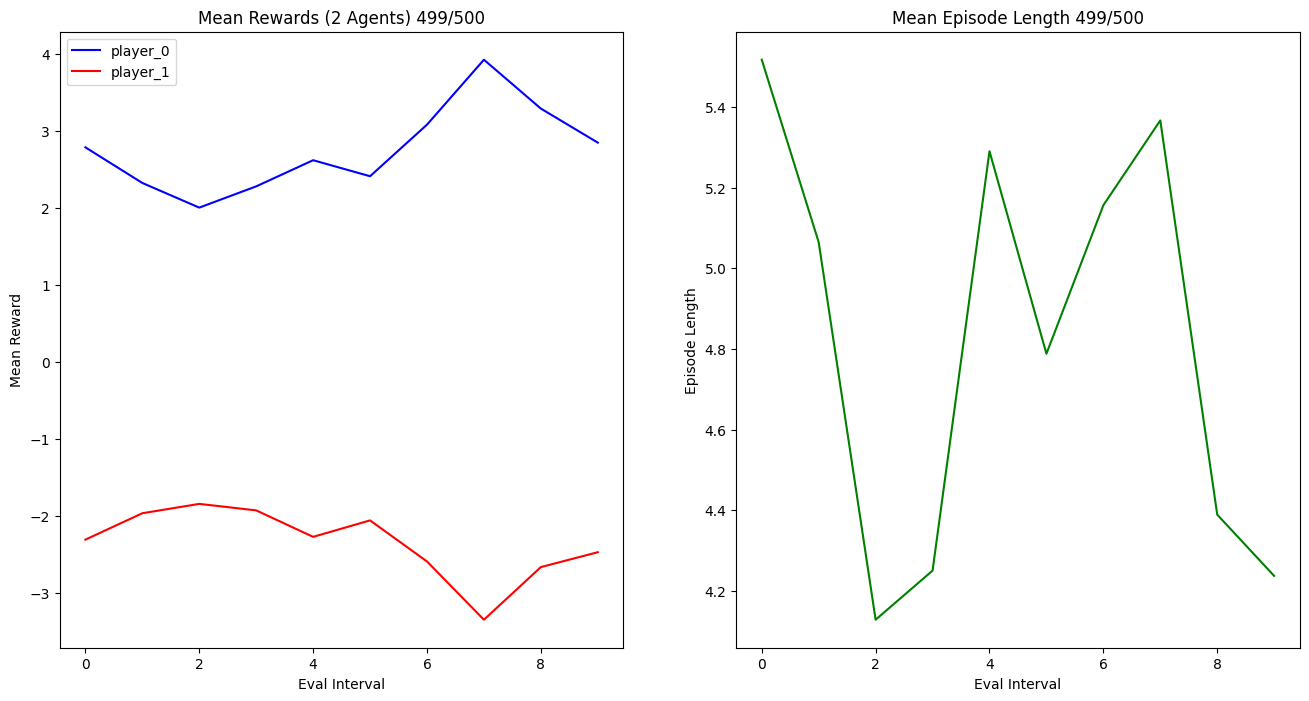

In [12]:
TRAINING_ITERATIONS = 500
import pickle
EVAL_INTERVAL = 50
from tqdm import tqdm

with tqdm(total=TRAINING_ITERATIONS, desc="Training", unit="iter") as pbar:
    for i in range(TRAINING_ITERATIONS):
        algo.train()

        if (i+1) % EVAL_INTERVAL == 0:
            # metrics = algo.evaluate()['evaluation']
            # rewards.append(metrics['episode_reward_mean'])
            # lengths.append(metrics['episode_len_mean'])
            metrics = algo.evaluate()
            metrics = metrics["env_runners"]

            # r_mean = metrics["episode_return_mean"]
            a1_reward.append(metrics["policy_reward_mean"]["learner"])
            a2_reward.append(metrics["policy_reward_mean"]["bot"])

            l_mean = metrics["episode_len_mean"]

            # rewards.append(r_mean)
            lengths.append(l_mean)
            plot_metrics(a1_reward, a2_reward, lengths, i, TRAINING_ITERATIONS)
            algo.save("./checkpoints_2")
        #pbar.update(1)

In [13]:
import numpy as np

SUITS = ["Spades", "Hearts", "Diamonds", "Clubs"]
RANKS = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K"]

def decode_visible_cards(obs_dict):
    """Return list of human-readable cards visible to this player."""
    vec = obs_dict["observation"]
    # ensure it's a flat array
    vec = np.array(vec).astype(int)

    cards_bits = vec[:52]
    cards = []
    for i, bit in enumerate(cards_bits):
        if bit == 1:
            suit = SUITS[i // 13]
            rank = RANKS[i % 13]
            cards.append(f"{rank} of {suit}")
    return cards
ACTION_NAMES = {
    0: "Call",
    1: "Raise",
    2: "Fold",
    3: "Check",
}


In [ ]:
import imageio
import torch
from PIL import Image

rmode = "rgb_array"

env = texas_holdem_v4.env(render_mode=rmode)
env.reset()
frames = []
for agent in env.agent_iter():
    print("-------------------")
    print(agent)
    obs, reward, termination, truncation, info = env.last()
    visible_cards = decode_visible_cards(obs)
    print("Visible cards:", visible_cards)
    print("Reward so far:", reward)

    if termination or truncation:
        action = None
        print("-------------------")
    else:
        rllib_obs = {
            "action_mask": obs["action_mask"],
            "observation": obs["observation"],
        }

        policy_id = "learner" if agent == "player_0" else "bot"

        action = algo.compute_single_action(
            rllib_obs,
            policy_id=policy_id,
            explore=False,
        )
        action_name = ACTION_NAMES.get(int(action), f"Unknown({action})")
        print("Chosen action:", action_name)
        print("-------------------")

    if rmode == "rgb_array":
        frame = env.render()
        if frame is not None:
            frames.append(frame)
    env.step(action)


env.close()


if rmode != "human":
   imageio.mimsave("ppo_poke.gif", frames, fps=2)
   print("Saved to ppo_poke.gif")

-------------------
player_1
Visible cards: ['A of Hearts', '6 of Diamonds']
Reward so far: 0
Chosen action: Raise
-------------------
-------------------
player_0
Visible cards: ['6 of Spades', '10 of Spades']
Reward so far: 0
Chosen action: Raise
-------------------
-------------------
player_1
Visible cards: ['A of Hearts', '6 of Diamonds']
Reward so far: 0
Chosen action: Raise
-------------------
-------------------
player_0
Visible cards: ['6 of Spades', '10 of Spades']
Reward so far: 0
Chosen action: Raise
-------------------
-------------------
player_1
Visible cards: ['A of Hearts', '6 of Diamonds']
Reward so far: 0
Chosen action: Fold
-------------------
-------------------
player_0
Visible cards: ['6 of Spades', '10 of Spades']
Reward so far: 4.0
-------------------
-------------------
player_1
Visible cards: ['A of Hearts', '6 of Diamonds']
Reward so far: -4.0
-------------------
Saved to ppo_poke.gif


In [42]:
import numpy as np
from collections import Counter
from pettingzoo.classic import texas_holdem_v4


In [43]:
# ===================== 辅助：解码可见牌 =====================

SUITS = ["Spades", "Hearts", "Diamonds", "Clubs"]
RANKS = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K"]

def rb_decode_visible_cards(obs_dict):
    """
    把 texas_holdem_v4 的 observation 向量前 52 维解码成牌：
    返回 [(rank, suit), ...]，只在 rule-based 里用，不影响 PPO。
    """
    vec = np.asarray(obs_dict["observation"]).astype(int)
    card_bits = vec[:52]
    cards = []
    for idx, bit in enumerate(card_bits):
        if bit == 1:
            suit = SUITS[idx // 13]
            rank = RANKS[idx % 13]
            cards.append((rank, suit))
    return cards

def rb_get_street(obs_dict):
    """
    粗略判断当前处于哪一轮：
        <=2 张牌: preflop
        <=5 张牌: flop
        <=6 张牌: turn
        >=7 张牌: river
    返回 0/1/2/3
    """
    cards = rb_decode_visible_cards(obs_dict)
    n = len(cards)
    if n <= 2:
        return 0
    elif n <= 5:
        return 1
    elif n <= 6:
        return 2
    else:
        return 3

def rb_estimate_strength(cards):
    """
    非常粗糙的牌力估计: 0=weak, 1=medium, 2=strong
    规则：
      - 三条以上 或 同花(>=5) -> strong
      - 一对 或 有 Q/K/A -> medium
      - 否则 -> weak
    """
    if not cards:
        return 0
    ranks = [r for (r, s) in cards]
    suits = [s for (r, s) in cards]

    rc = Counter(ranks)
    sc = Counter(suits)

    max_same_rank = max(rc.values())
    max_same_suit = max(sc.values())
    has_high = any(r in ["Q", "K", "A"] for r in ranks)

    if max_same_rank >= 3 or max_same_suit >= 5:
        return 2
    if max_same_rank == 2 or has_high:
        return 1
    return 0

def rb_pick_legal(preferred, legal, backup_order):
    """
    给定首选动作 preferred，如果不合法则按 backup_order 找下一个合法的。
    legal: np.array of legal action indices
    """
    legal_set = set(int(a) for a in legal)
    if preferred in legal_set:
        return preferred
    for a in backup_order:
        if a in legal_set:
            return a
    return int(list(legal_set)[0])

def rule_based_action(obs_dict, verbose=False, who="player_0"):
    """
    简单 rule-based 策略：
    动作编码：0=Call, 1=Raise, 2=Fold, 3=Check
    """
    mask = np.asarray(obs_dict["action_mask"])
    legal = np.where(mask > 0)[0]

    street = rb_get_street(obs_dict)
    cards = rb_decode_visible_cards(obs_dict)
    strength = rb_estimate_strength(cards)

    if verbose:
        readable = [f"{r} of {s}" for (r, s) in cards]
        label = ["weak", "medium", "strong"][strength]
        street_name = ["preflop", "flop", "turn", "river"][street]
        print(f"[{who}] street={street_name} cards={readable} | strength={label}")

    # 0=Call, 1=Raise, 2=Fold, 3=Check
    if street == 0:  # preflop
        if strength == 2:      # strong
            action = rb_pick_legal(1, legal, backup_order=[0, 3, 2])
        elif strength == 1:    # medium
            action = rb_pick_legal(0, legal, backup_order=[3, 1, 2])
        else:                  # weak
            action = rb_pick_legal(3, legal, backup_order=[2, 0, 1])
    else:          # flop/turn/river
        if strength == 2:
            action = rb_pick_legal(1, legal, backup_order=[0, 3, 2])
        elif strength == 1:
            action = rb_pick_legal(0, legal, backup_order=[3, 1, 2])
        else:
            action = rb_pick_legal(3, legal, backup_order=[2, 0, 1])

    return int(action)

def eval_rule_based_vs_random(num_episodes=500):
    """
    评估：player_0 = rule-based, player_1 = random
    返回 rewards_p0 数组方便画图，顺便打印胜率。
    """
    rewards_p0 = []

    for ep in range(num_episodes):
        env = texas_holdem_v4.env()
        env.reset()
        total_reward_p0 = 0.0

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            done = termination or truncation

            if agent == "player_0":
                total_reward_p0 += reward

            if done:
                action = None
            else:
                mask = np.asarray(obs["action_mask"])
                legal = np.where(mask > 0)[0]
                if agent == "player_0":
                    action = rule_based_action(obs, verbose=False, who=agent)
                else:
                    action = int(np.random.choice(legal))

            env.step(action)

        env.close()
        rewards_p0.append(total_reward_p0)

    rewards_p0 = np.array(rewards_p0)
    win_rate = np.mean(rewards_p0 > 0)
    tie_rate = np.mean(rewards_p0 == 0)
    loss_rate = np.mean(rewards_p0 < 0)

    print(f"[Rule-based vs Random] over {num_episodes} episodes:")
    print(f"  Win rate : {win_rate:.3f}")
    print(f"  Tie rate : {tie_rate:.3f}")
    print(f"  Loss rate: {loss_rate:.3f}")
    print(f"  Mean reward: {rewards_p0.mean():.3f}")

    return rewards_p0


In [44]:
rb_rewards = eval_rule_based_vs_random(num_episodes=500)


[Rule-based vs Random] over 500 episodes:
  Win rate : 0.572
  Tie rate : 0.004
  Loss rate: 0.424
  Mean reward: 0.425


In [45]:
def eval_ppo_vs_random(algo, num_episodes=500):
    """
    评估：player_0 = PPO learner policy, player_1 = random baseline
    algo: 训练好的 RLlib Algorithm（里面有名字为 "learner" 的 policy）
    """
    rewards_p0 = []
    rewards_p1 = []

    for ep in range(num_episodes):
        env = texas_holdem_v4.env()
        env.reset()
        ep_reward = {"player_0": 0.0, "player_1": 0.0}

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            ep_reward[agent] += reward
            done = termination or truncation

            if done:
                action = None
            else:
                mask = np.asarray(obs["action_mask"]).flatten()

                if agent == "player_0":
                    # --- PPO learner ---
                    rllib_obs = {
                        "observation": obs["observation"],
                        "action_mask": mask,
                    }
                    ret = algo.compute_single_action(
                        rllib_obs,
                        policy_id="learner",   # ✅ 一定用 learner 这个 policy
                        explore=False,
                    )
                    action = int(ret[0] if isinstance(ret, (tuple, list)) else ret)
                else:
                    # --- Random baseline ---
                    legal = np.where(mask > 0)[0]
                    if legal.size == 0:
                        n = int(mask.shape[0]) if mask.shape[0] > 0 else 1
                        action = int(np.random.randint(0, n))
                    else:
                        action = int(np.random.choice(legal))

            env.step(action)

        env.close()
        rewards_p0.append(ep_reward["player_0"])
        rewards_p1.append(ep_reward["player_1"])

    rewards_p0 = np.array(rewards_p0)
    rewards_p1 = np.array(rewards_p1)

    win_rate_p0 = np.mean(rewards_p0 > 0)
    win_rate_p1 = np.mean(rewards_p1 > 0)
    tie_rate    = np.mean(rewards_p0 == 0)

    stats = {
        "mean_reward_p0": float(rewards_p0.mean()),
        "mean_reward_p1": float(rewards_p1.mean()),
        "std_reward_p0": float(rewards_p0.std()),
        "std_reward_p1": float(rewards_p1.std()),
        "win_rate_p0": float(win_rate_p0),
        "win_rate_p1": float(win_rate_p1),
        "tie_rate": float(tie_rate),
    }

    print(f"[PPO vs Random] over {num_episodes} episodes:")
    print(f"  PPO mean reward : {stats['mean_reward_p0']:.3f}")
    print(f"  PPO win rate    : {stats['win_rate_p0']:.3f}")
    print(f"  Random win rate : {stats['win_rate_p1']:.3f}")
    print(f"  Tie rate        : {stats['tie_rate']:.3f}")

    return stats


In [46]:
ppo_stats = eval_ppo_vs_random(algo, num_episodes=500)
print(ppo_stats)


[PPO vs Random] over 500 episodes:
  PPO mean reward : 2.791
  PPO win rate    : 0.972
  Random win rate : 0.024
  Tie rate        : 0.004
{'mean_reward_p0': 2.791, 'mean_reward_p1': -2.791, 'std_reward_p0': 3.830772637471454, 'std_reward_p1': 3.830772637471454, 'win_rate_p0': 0.972, 'win_rate_p1': 0.024, 'tie_rate': 0.004}


In [47]:
rb_win = 0.572
rb_mean = 0.425

ppo_win = 0.972
ppo_mean = 2.791


In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# === 你的实验结果 ===
data = {
    "Agent": ["Rule-based", "PPO (learner)"],
    "Opponent": ["Random", "Random"],
    "Win Rate": [rb_win, ppo_win],
    "Mean Reward": [rb_mean, ppo_mean]
}

df = pd.DataFrame(data)
df


,Agent,Opponent,Win Rate,Mean Reward
0,Rule-based,Random,0.572,0.425
1,PPO (learner),Random,0.972,2.791


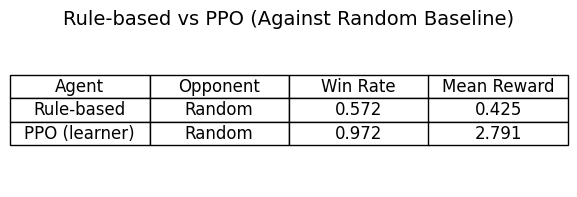

In [49]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.4)

plt.title("Rule-based vs PPO (Against Random Baseline)", fontsize=14)
plt.savefig("baseline_comparison.png", dpi=200, bbox_inches='tight')
plt.show()
